# Simulez un contrat de maintenance

In [1]:
# Standard libs
import os
import warnings

# Data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# SciPy (dendrogram / linkage si besoin)
from scipy.cluster.hierarchy import dendrogram, linkage

# Scikit-learn (clustering, préprocessing, métriques, PCA, utilitaires)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs, make_moons

# Supprimer les warnings silencieusement (comme dans ton script)
warnings.filterwarnings('ignore')


In [2]:
# Calcul des valeurs manquantes par colonne
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# 3 - Stabilité temporelle

Dans cette partie, on va faire un clustering tous les 6 mois. Donc comme l'étude se déroule sur 2 ans, il y aura 4 clusterings.

In [3]:
df_timestamp = pd.read_csv("../data/processed/customer_rfm_final_with_timestamp.csv")
df_timestamp = df_timestamp[['mean_price', 'average_reviewed_score', 'recency_score', 'frequency_score', 'monetary_score', 'last_session_timestamp']]
df_timestamp


,mean_price,average_reviewed_score,recency_score,frequency_score,monetary_score,last_session_timestamp
0,124.99,4.0,1,1,2,2017-05-16 15:05:35
1,289.00,5.0,1,1,3,2018-01-12 20:48:24
2,139.94,5.0,1,1,2,2018-05-19 16:07:45
3,149.94,5.0,1,1,2,2018-03-13 16:06:38
4,230.00,5.0,1,1,3,2018-07-29 09:51:30
...,...,...,...,...,...,...
98661,74.90,4.0,1,1,1,2018-04-07 15:48:17
98662,114.90,5.0,1,1,2,2018-04-04 08:20:22
98663,37.00,1.0,1,1,1,2018-04-08 20:11:50
98664,689.00,5.0,1,1,4,2017-11-03 21:08:33


In [4]:
missing_values_table(df_timestamp)

Your selected dataframe has 6 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
average_reviewed_score,749,0.8


In [5]:
df_timestamp.dropna(inplace=True)
len(df_timestamp)

97917

In [6]:
print(f"La première session est {df_timestamp['last_session_timestamp'].min()}")
print(f"La dernière session est {df_timestamp['last_session_timestamp'].max()}")



La première session est 2016-09-04 21:15:19
La dernière session est 2018-09-03 09:06:57


In [7]:
# make sure column is datetime
df_timestamp['last_session_timestamp'] = pd.to_datetime(df_timestamp['last_session_timestamp'])

start = df_timestamp['last_session_timestamp'].min()

# boundaries at 6-month steps
b6  = start + pd.DateOffset(months=6)
b12 = start + pd.DateOffset(months=12)
b18 = start + pd.DateOffset(months=18)
b24 = start + pd.DateOffset(months=24)

# 4 boolean filters
f1 = (df_timestamp['last_session_timestamp'] >= start) & (df_timestamp['last_session_timestamp'] <  b6)
f2 = (df_timestamp['last_session_timestamp'] >= b6)    & (df_timestamp['last_session_timestamp'] <  b12)
f3 = (df_timestamp['last_session_timestamp'] >= b12)   & (df_timestamp['last_session_timestamp'] <  b18)
f4 = (df_timestamp['last_session_timestamp'] >= b18)   & (df_timestamp['last_session_timestamp'] <= b24)  # include right bound

# 4 filtered DataFrames
df_s1 = df_timestamp[f1].copy()
df_s2 = df_timestamp[f2].copy()
df_s3 = df_timestamp[f3].copy()
df_s4 = df_timestamp[f4].copy()

# quick check
print(len(df_s1), len(df_s2), len(df_s3), len(df_s4))
print(df_s1['last_session_timestamp'].min(), df_s1['last_session_timestamp'].max())
print(df_s4['last_session_timestamp'].min(), df_s4['last_session_timestamp'].max())


3110 20216 35906 38685
2016-09-04 21:15:19 2017-03-04 21:08:40
2018-03-04 21:25:15 2018-09-03 09:06:57


In [8]:
X_s1 = df_s1
X_s1.drop(columns=['last_session_timestamp'], inplace=True)
X_s1

,mean_price,average_reviewed_score,recency_score,frequency_score,monetary_score
48,223.9,5.0,1,1,3
110,239.0,5.0,1,1,3
118,184.9,1.0,1,1,3
128,168.0,5.0,1,1,2
143,635.9,4.0,1,1,4
...,...,...,...,...,...
98513,24.9,4.0,1,1,1
98555,209.9,5.0,1,1,3
98584,6.9,4.0,1,1,1
98588,20.9,3.0,1,1,1


In [9]:
"""X_s2 = df_s2
X_s2.drop(columns=['last_session_timestamp'], inplace=True)

X_s3 = df_s3
X_s3.drop(columns=['last_session_timestamp'], inplace=True)

X_s4 = df_s4
X_s4.drop(columns=['last_session_timestamp'], inplace=True)"""

X_s2, X_s3, X_s4 = [df.drop(columns=['last_session_timestamp']) for df in [df_s2, df_s3, df_s4]]


Faire les algorithmes de clustering dans un nouveau notebook (étude de la temporalité.).  
Revoir le DB scan

# On détermine le nombre optimal de clusters avec le diagramme du coude

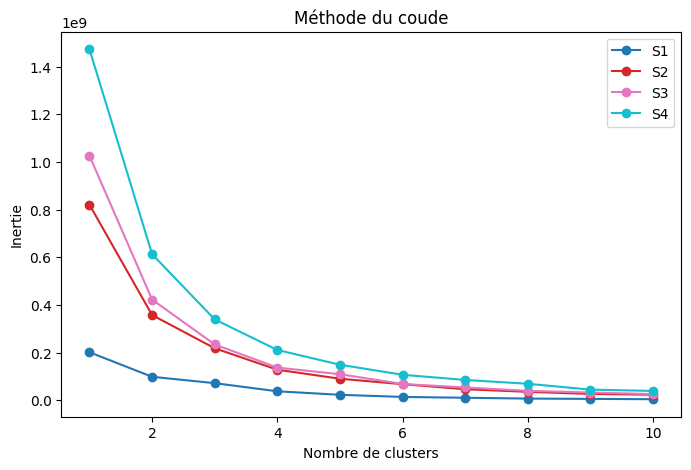

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Créer la figure
plt.figure(figsize=(8, 5))

# Créer une palette de 4 couleurs distinctes
colors = plt.cm.tab10(np.linspace(0, 1, 4))  # palette harmonieuse (tab10 = 10 couleurs bien contrastées)

# Boucle sur tes datasets
for X, color, label in zip([X_s1, X_s2, X_s3, X_s4], colors, ['S1', 'S2', 'S3', 'S4']):
    inertias = []
    k_range = range(1, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    # Tracer la courbe avec une couleur unique
    plt.plot(k_range, inertias, color=color, marker='o', label=label)

# Personnalisation du graphique
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.legend()
plt.show()

D'après la méthode du coude, on trouve un nombre de clusters autour de 4 pour chacun des datasets

# Clustering avec Kmeans

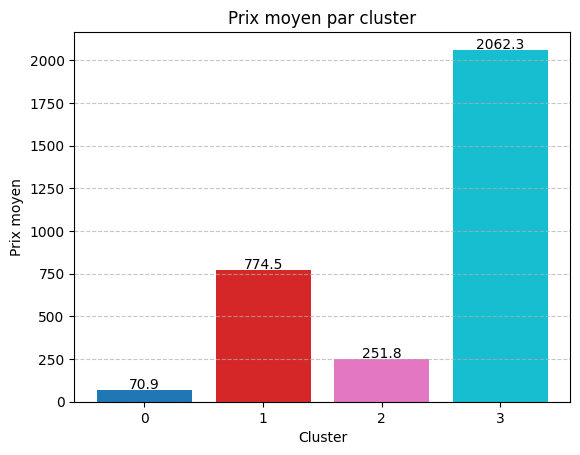

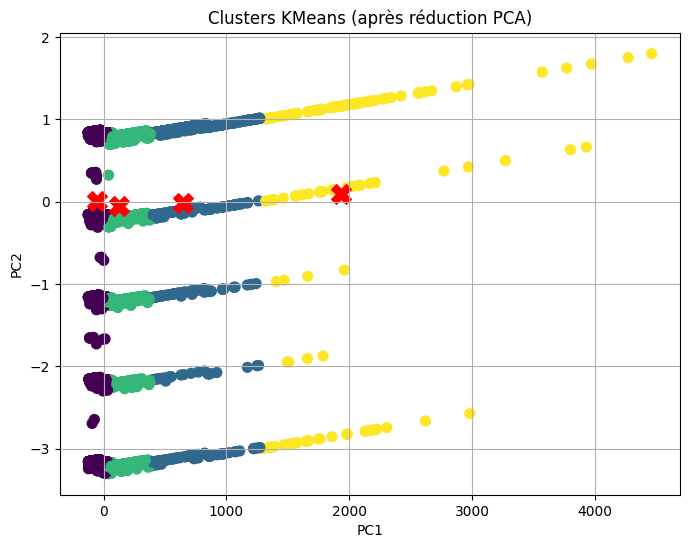

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_s4)
X_s4['cluster'] = kmeans.labels_
moyennes = X_s4.groupby('cluster')['mean_price'].mean()

# Création du barchart
# Palette de couleurs (autant que de clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(moyennes)))

# Création du barchart
plt.bar(moyennes.index, moyennes.values, color=colors)

# Ajout des labels sur chaque barre
for i, val in enumerate(moyennes.values):
    plt.text(moyennes.index[i], val + 5, f'{val:.1f}', ha='center', fontsize=10)

# Paramètres du graphique
plt.xlabel('Cluster')
plt.ylabel('Prix moyen')
plt.title('Prix moyen par cluster')
plt.xticks(moyennes.index)  # S'assurer que chaque cluster est affiché
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_s4)

# Fit et plot avec données réduites
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200)
plt.title("Clusters KMeans (après réduction PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [12]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_s4)
kmeans

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


In [13]:
X_s4['cluster'] = kmeans.labels_

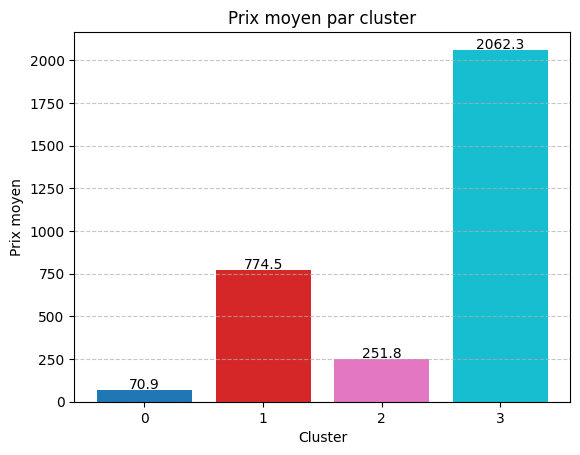

In [14]:
moyennes = X_s4.groupby('cluster')['mean_price'].mean()

# Création du barchart
# Palette de couleurs (autant que de clusters)
colors = plt.cm.tab10(np.linspace(0, 1, len(moyennes)))

# Création du barchart
plt.bar(moyennes.index, moyennes.values, color=colors)

# Ajout des labels sur chaque barre
for i, val in enumerate(moyennes.values):
    plt.text(moyennes.index[i], val + 5, f'{val:.1f}', ha='center', fontsize=10)

# Paramètres du graphique
plt.xlabel('Cluster')
plt.ylabel('Prix moyen')
plt.title('Prix moyen par cluster')
plt.xticks(moyennes.index)  # S'assurer que chaque cluster est affiché
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

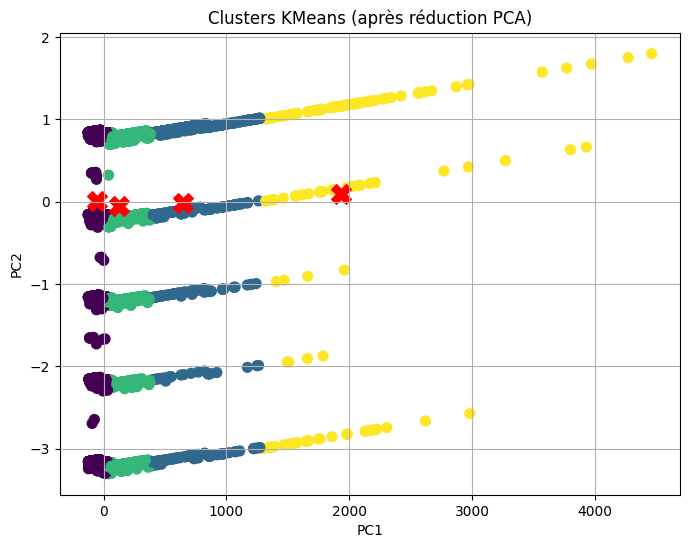

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_s4)

# Fit et plot avec données réduites
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200)
plt.title("Clusters KMeans (après réduction PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


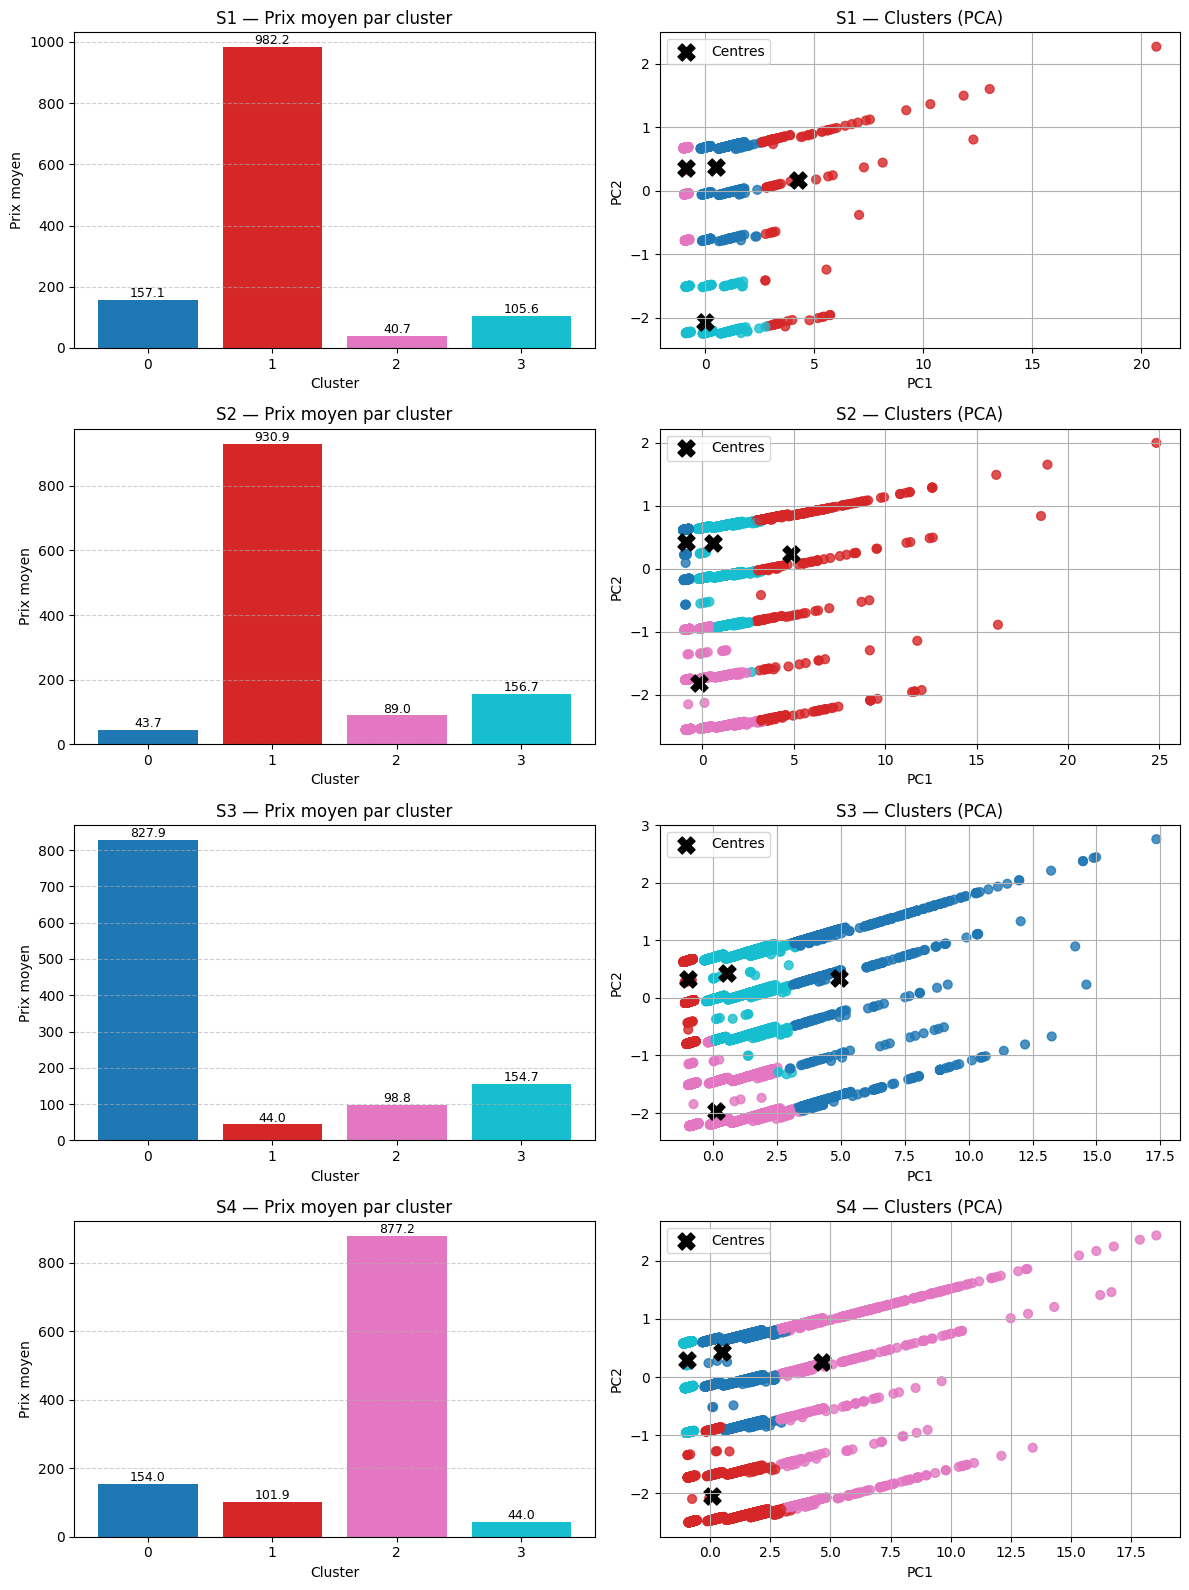

In [16]:
# Paramètres
datasets = [X_s1, X_s2, X_s3, X_s4]
labels = ['S1', 'S2', 'S3', 'S4']
n_clusters = 4

# Figure avec 4 lignes x 2 colonnes (bar chart | PCA)
fig, axes = plt.subplots(nrows=len(datasets), ncols=2, figsize=(12, 4 * len(datasets)))

# Assure que axes est indexable même si nrows==1
axes = np.atleast_2d(axes)

for i, (ds, lab) in enumerate(zip(datasets, labels)):
    ax_bar = axes[i, 0]
    ax_pca = axes[i, 1]

    # Travailler sur une copie pour ne pas altérer l'original
    X = ds.copy()

    # Sélection des colonnes numériques pour le clustering (exclut la colonne 'cluster' si présente)
    numeric = X.select_dtypes(include=[np.number]).copy()
    if 'cluster' in numeric.columns:
        numeric = numeric.drop(columns=['cluster'])

    if numeric.shape[1] == 0:
        ax_bar.text(0.5, 0.5, 'Aucune variable numérique', ha='center', va='center')
        ax_pca.text(0.5, 0.5, 'Aucune variable numérique', ha='center', va='center')
        continue

    # Standardisation (recommandée pour KMeans / PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(numeric)

    # KMeans sur les features normalisées
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X_scaled)
    X['cluster'] = kmeans.labels_

    # --- BARCHART (prix moyen par cluster) ---
    if 'mean_price' in X.columns:
        moyennes = X.groupby('cluster')['mean_price'].mean().sort_index()
    else:
        # fallback : prendre la première colonne numérique si mean_price absente
        first_num = numeric.columns[0]
        moyennes = X.groupby('cluster')[first_num].mean().sort_index()

    # Palette et cmap cohérente entre bar et scatter
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    cmap = ListedColormap(colors)

    # Barres (on s'assure de prendre la même longueur que le nombre de clusters réellement présents)
    clusters_idx = moyennes.index.values
    ax_bar.bar(clusters_idx, moyennes.values, color=colors[:len(clusters_idx)])
    for j, val in enumerate(moyennes.values):
        ax_bar.text(clusters_idx[j], val + 0.01 * (moyennes.max() - moyennes.min() + 1), f'{val:.1f}', 
                    ha='center', fontsize=9)
    ax_bar.set_xlabel('Cluster')
    ax_bar.set_ylabel('Prix moyen' if 'mean_price' in X.columns else first_num)
    ax_bar.set_title(f'{lab} — Prix moyen par cluster')
    ax_bar.set_xticks(clusters_idx)
    ax_bar.grid(axis='y', linestyle='--', alpha=0.6)

    # --- PCA & scatter ---
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Centres de clusters en coordonnées PCA
    centers_pca = pca.transform(kmeans.cluster_centers_)

    sc = ax_pca.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap=cmap, s=40, alpha=0.8)
    ax_pca.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='X', s=150, label='Centres')
    ax_pca.set_title(f'{lab} — Clusters (PCA)')
    ax_pca.set_xlabel('PC1')
    ax_pca.set_ylabel('PC2')
    ax_pca.grid(True)
    ax_pca.legend()

# Mise en page propre
plt.tight_layout()
plt.show()


Comment interpréter les graphiques de PCA

A faire : écrire une page de conclusion sur l'interprétation des graphiques
Vu que le profil du clustering et de la PCA semblent identiques, on peut dire qu'il y a une certaine stabilité des clusters dans le temps.